In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import NetworkOptimizer, fast_evaluator, density_distance, ParallelNetworkOptimizer
import seaborn as sns

In [3]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/human/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

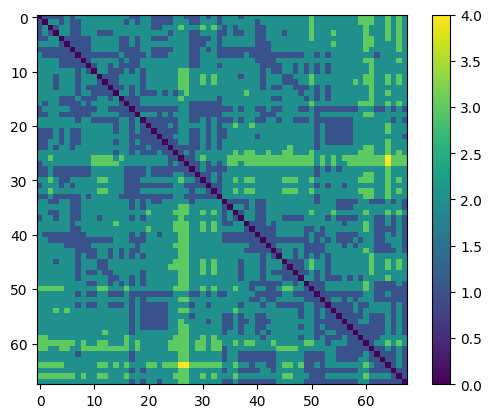

In [4]:
plt.imshow(gen.shortest_path_distance(connectivity, coordinates))
plt.colorbar()

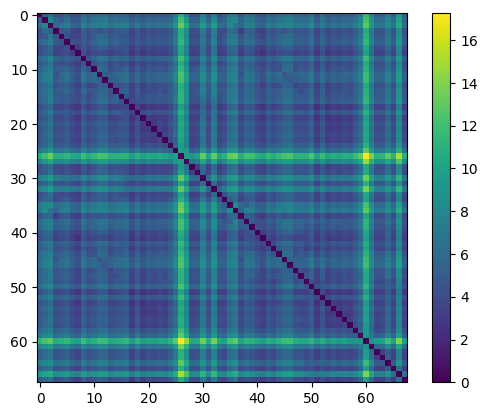

In [5]:
plt.imshow(gen.resistance_distance(connectivity, coordinates))
plt.colorbar()

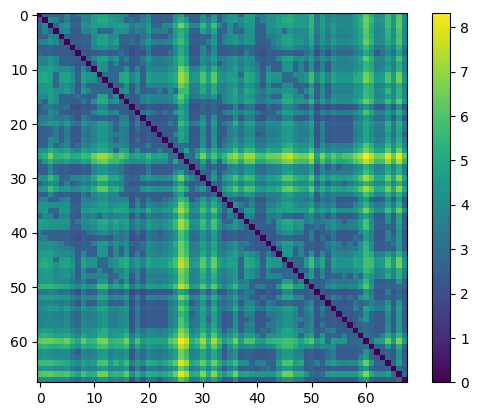

In [6]:
plt.imshow(gen.propagation_distance(connectivity, coordinates))
plt.colorbar()

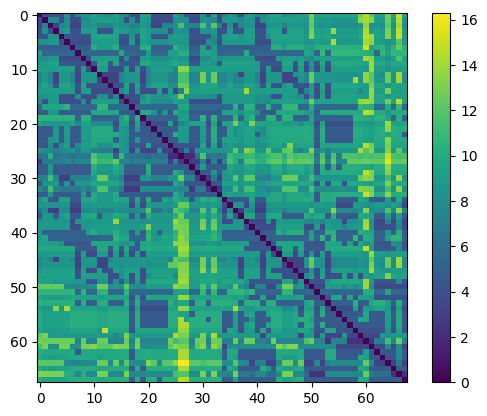

In [7]:
plt.imshow(gen.search_information(connectivity, coordinates))
plt.colorbar()

In [8]:
optimizer = ParallelNetworkOptimizer(
    simulation_model=gen.simulate_network_evolution,
    evaluation_function=density_distance,
    param_bounds={
        'alpha': (0.01, 1),
        'beta': (0.01, 1)
    },
    sim_kwargs={
        'coordinates': coordinates,
        'n_iterations': 100,
        'distance_fn': gen.resistance_distance,
        'noise': np.zeros(100),
        'connectivity_penalty': np.zeros(100),
    },
    eval_kwargs={
        'empirical': connectivity
    }
)

results = optimizer.optimize(
    n_particles=2,
    n_iterations=2,
)

2025-01-28 19:35:55,235 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7, 'k': 16, 'p': 2}
Simulating network evolution:   0%|          | 0/99 [00:00<?, ?it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
pyswarms.single.global_best:   0%|          |0/2


KeyboardInterrupt: 

Simulating network evolution:   1%|          | 1/99 [00:41<1:08:14, 41.78s/it]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
Simulating network evolution:   1%|          | 1/99 [00:42<1:08:51, 42.15s/it]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/joblib/parallel.py:1359: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,


In [8]:
# Create parameter trajectories
n_iterations = 2500
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, 1.6)
beta = np.full(n_iterations, 0.1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)

# Run simulation
history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    alpha=alpha,
    beta=beta,
    noise=noise,
    distance_fn=gen.resistance_distance,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=11,
    batch_size=32,
)

Simulating network evolution:  34%|███▎      | 840/2499 [01:06<02:10, 12.70it/s]


KeyboardInterrupt: 

In [9]:
results.best_parameters

{'alpha': 0.9923564853862997, 'beta': 0.08535863512693485}

In [12]:
results.best_score

0.14186851211072665

In [15]:
np.array(results.position_history).shape

(3, 5, 2)

In [28]:
optimizer = NetworkOptimizer(
        coordinates=coordinates,
        empirical_network=connectivity,
        n_iterations=5000,
        random_seed=11,
        distance_fn=gen.shortest_path_distance,
        evaluator=density_distance,
    )
    
# Define parameter ranges
param_ranges = {
    'alpha': (0.01, 1),
    'beta': (0.01, 1),
}

# Run optimization
results = optimizer.optimize(
    param_ranges=param_ranges,
    n_calls=32,
    n_parallel_samples=1,
    verbose=True,
    acquisition_function='EI',
)

Running Bayesian optimization...


Simulating network evolution: 100%|██████████| 4999/4999 [02:28<00:00, 33.58it/s]


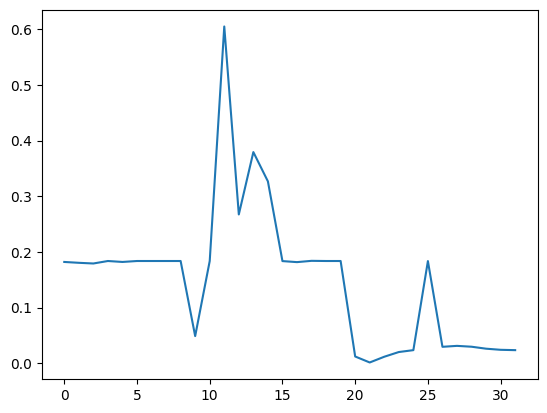

In [29]:
plt.plot(results.all_scores);

In [31]:
results.best_score

0.001231148045552466

In [30]:
results.best_parameters

{'alpha': 0.40678665646677614, 'beta': 0.01}

In [32]:
# Create parameter trajectories
n_iterations = 15_000
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, results.best_parameters["alpha"])
beta = np.full(n_iterations, results.best_parameters["beta"])
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)

# Run simulation
history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    alpha=alpha,
    beta=beta,
    noise=noise,
    distance_fn=gen.shortest_path_distance,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=11,
    batch_size=32,
)

Simulating network evolution: 100%|██████████| 14999/14999 [09:07<00:00, 27.38it/s]


In [33]:
np.sum(history[:,:,-1])/(connectivity.shape[0])**2

0.1997537703908895

In [34]:
np.sum(connectivity)/(connectivity.shape[0])**2

0.20098491843644198

In [38]:
# Vectorized correlation computation
flattened_history = history.reshape(history.shape[0] * history.shape[1], history.shape[2])
corr_matrix = np.corrcoef(flattened_history.T)


<Axes: >

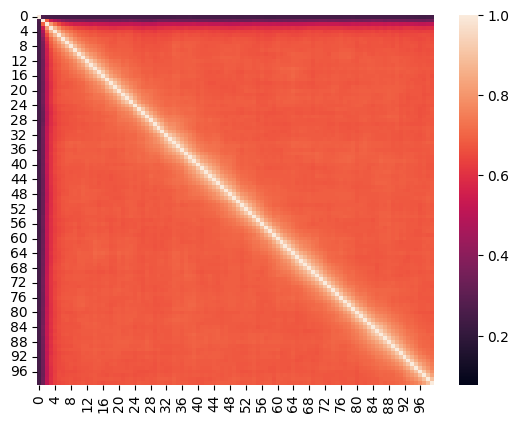

In [47]:
sns.heatmap(corr_matrix[::150,::150],vmin=corr_matrix.min(),vmax=1)

In [44]:
corr_matrix.min()

0.07771471386648207

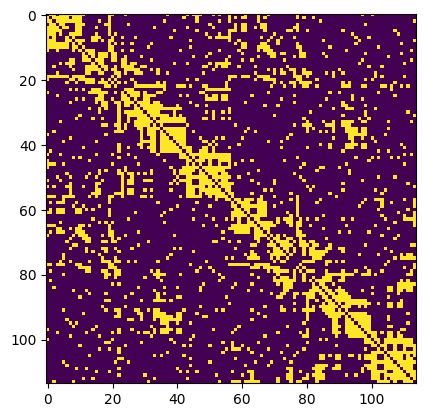

In [49]:
plt.imshow(history[:,:,-1])

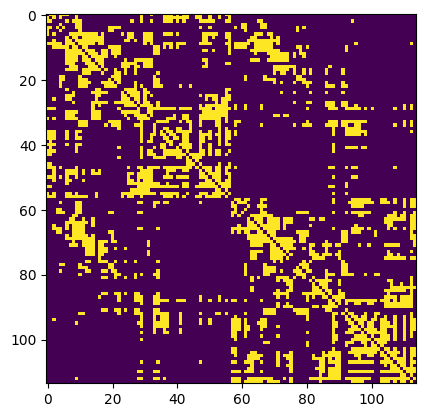

In [48]:
plt.imshow(connectivity)

In [51]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution: 100%|██████████| 15000/15000 [03:09<00:00, 79.00it/s]


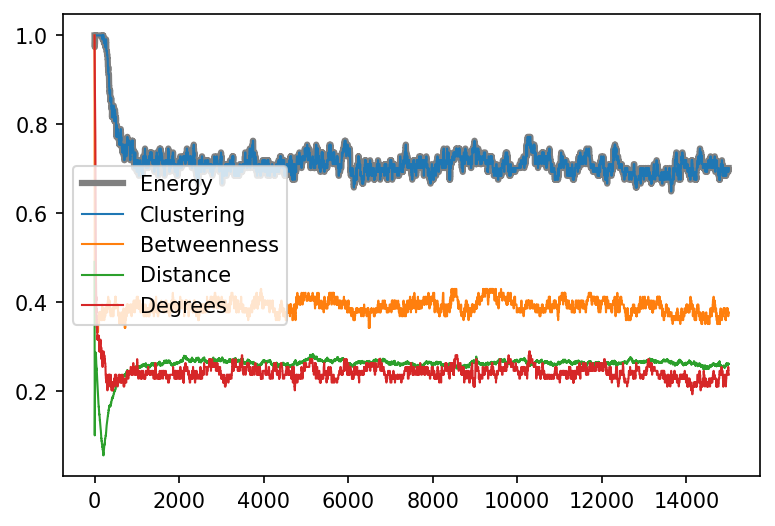

In [52]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

In [290]:
np.min(energy_vector)

0.5037744737091552

In [291]:
np.argmin(energy_vector)

3768

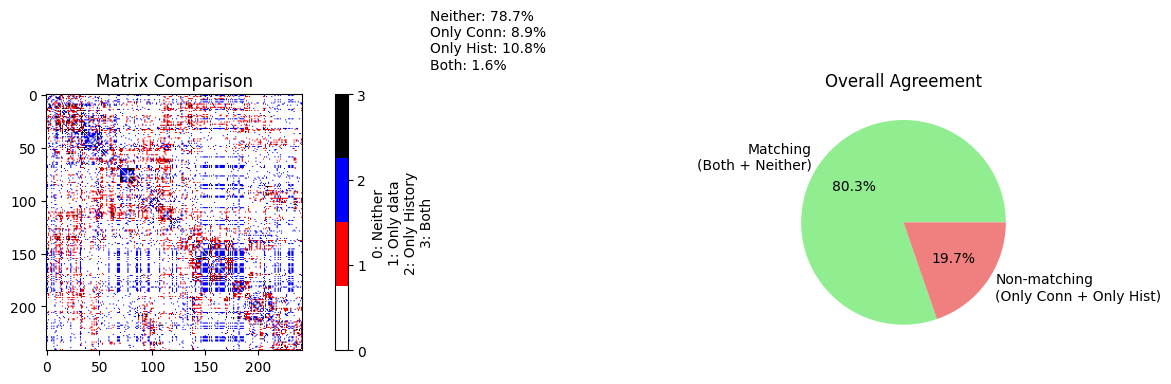

In [292]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
min_energy_point = energy_vector.argmin()

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only data (red)
# 2: only history (blue)
# 3: both (black)
comparison = data.astype(int) + 2 * history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only data\n2: Only History\n3: Both')

# Add percentage text
total = data.shape[0] * data.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 20000/20000 [01:12<00:00, 276.33it/s]


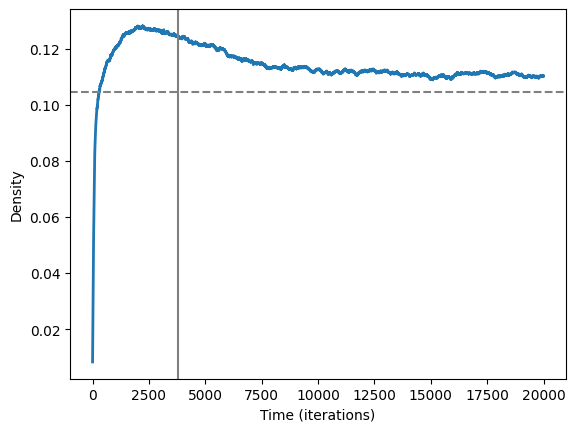

In [293]:
density = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(data))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')


In [88]:
import seaborn as sns

In [89]:
history[:,:,-1].astype(int).shape

(242, 242)

In [90]:
data.astype(int).shape

(242, 242)

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_3392/1531759925.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


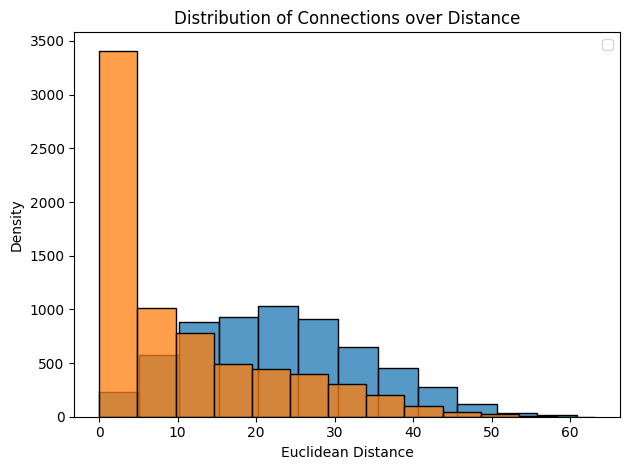

In [270]:
sns.histplot(macaque_euclidean_dist[data],binwidth=5)
what = history[:,:,-1].astype(bool)
sns.histplot(macaque_euclidean_dist[what],binwidth=5)

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

In [95]:
what

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
connectivity

array([[False,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])